In [1]:
from utils import *

In [2]:
plt.rcParams["figure.facecolor"] = "white"

In [3]:
pool = Pool(4)

In [1]:
B,g0, b,ka=0.05, 0.3, 1, 1
R,S,H,_ = get_RSH_harmonic_onlyka(1,g0,b,ka)

NameError: name 'get_RSH_harmonic_onlyka' is not defined

In [5]:
# params - A,B,C,D,F,g0,b,ka
params = [
]

As = np.arange(-8,3.1,0.20)
As = As[As>=-4]

As = np.arange(0.5,3.1,0.01)

params += [dict(A=A,B=B,g0=g0,b=b,ka=ka) for A in As]


df = pd.DataFrame(params, columns=["A","B","g0","b","ka"])

df["O+^2"],df["O-^2"] = omega_kumulant(df.A, df.B, df.g0, df.ka)

df["R"],df["S"],df["H"],df["varL"]=get_RSH_harmonic_onlyka(
                np.sqrt(df["O+^2"]),df.g0,df.b,df.ka)

In [6]:
df["S_init"] = df["S"]
df["R_init"] = df.R

df["H_init"] = df.H

In [7]:
df["S_init"] = 0
df["R_init"] = 0
df["H_init"] = 0

In [8]:
print(len(df));df.head()

260


,A,B,g0,b,ka,O+^2,O-^2,R,S,H,varL,S_init,R_init,H_init
0,0.50,0.05,0.3,1,1,1.128667,-0.295334,3.143335,5.714445,-1.666667,41.480384,0,0,0
1,0.51,0.05,0.3,1,1,1.136605,-0.293271,3.133023,5.727674,-1.666667,41.445420,0,0,0
2,0.52,0.05,0.3,1,1,1.144565,-0.291232,3.122824,5.740941,-1.666667,41.411457,0,0,0
3,0.53,0.05,0.3,1,1,1.152548,-0.289214,3.112738,5.754246,-1.666667,41.378482,0,0,0
4,0.54,0.05,0.3,1,1,1.160553,-0.287219,3.102764,5.767588,-1.666667,41.346483,0,0,0


In [10]:
N=5000000
warmup=0
dt=0.001
samples=1000
skip=10000
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

dump_to_disk = False

In [11]:
(len(df) * N * runs * samples *6 // skip) * 4 / 1024**3

17.434358596801758

In [16]:
get_cov(df.R_init, df.S_init, df.H_init).shape

(4, 4, 260)

In [17]:
results = []
sigmas = get_cov(df.R_init, df.S_init, df.H_init).transpose(2,0,1)

In [ ]:
for row, sigma in tqdm(zip(df.itertuples(),sigmas), total=len(df)):
#     if row.Index <40:
#         continue
    x0,y0,vx0,vy0 = np.random.multivariate_normal([0,0,0,0], sigma, samples).T
    z0,_,vz0,_    = np.random.multivariate_normal([0,0,0,0], sigma, samples).T
#     x0,y0,z0,vx0,vy0,vz0 = np.zeros(samples),np.zeros(samples),np.zeros(samples),np.zeros(samples),np.zeros(samples),np.zeros(samples)
    kwargs = dict(x0=x0,y0=y0,z0=z0,vx0=vx0,vy0=vy0,vz0=vz0,
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        A=row.A,B=row.B,
        gamma0=row.g0,b=row.b, kappa=row.ka)
    res = simulate_3d_only_memory_anharmonic_1(pool,runs,**kwargs)
    if dump_to_disk:
        np.save(f"results/{row.Index}", res)
    else:
#         pass
        results.append(np.array(res[:], dtype="float32"))

In [ ]:
results = np.array(results); results.shape

### Load dumped data

In [ ]:
results.shape

In [67]:
np.save("results", results)

In [12]:
results = np.load("results.npy")[-len(df):]

In [ ]:
import os
n_files = len(os.listdir("results"))

In [ ]:
np.load("results/1.npy").shape

In [ ]:
results = np.zeros((n_files, 4, 800, 5000))

In [ ]:
for i in tqdm(range(n_files)):
    results[i] = np.load(f"results/{i}.npy")[:4,:,-5000:]

In [10]:
results[:,:,:,:].shape

(36, 9, 1600, 1500)

### Start Analisys

In [20]:
cov_all = np.einsum("iakj,ibkj->ijab", results[:,:6,:,:],results[:,:6,:,:],optimize=True)/(results.shape[2]-1)
cov = cov_all[:, :1000]
# cov = cov[df[df.b].index]

In [21]:
sp = 10
cov_R = cov[:,::sp,(0,1),(0,1)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_Rz = cov[:,::sp,(2,),(2,)].transpose(1,0,2).reshape(-1, cov.shape[0])

cov_S = cov[:,::sp,(3,4),(3,4)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_Sz = cov[:,::sp,(5,),(5,)].transpose(1,0,2).reshape(-1, cov.shape[0])

cov_H = cov[:,::sp,(0,1,3,4),(4,3,1,0)].transpose(1,0,2).reshape(-1, cov.shape[0]*4)

cov_Zero = cov[:,::sp,(0,0,1,1,2,2,3,3),(1,2,0,3,0,3,1,2)].transpose(1,0,2).reshape(-1, cov.shape[0]*8)

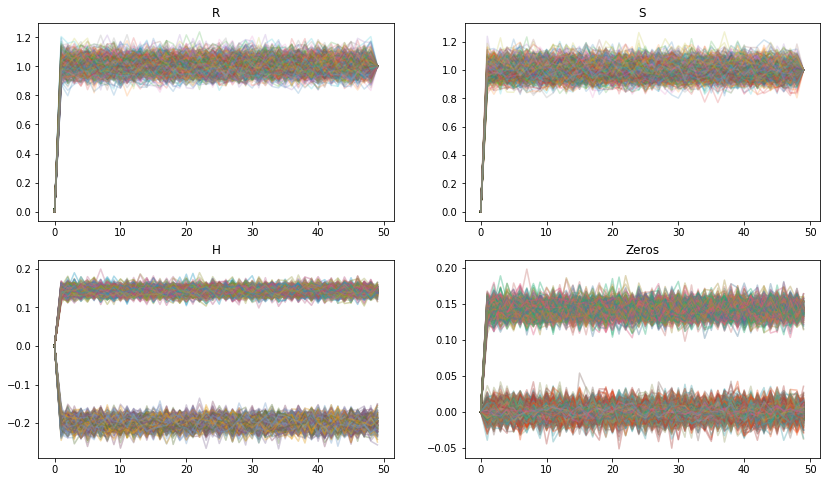

In [22]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(cov_R/cov_R[-1], alpha=0.2);plt.title("R")
plt.subplot(2,2,2)
plt.plot(cov_S/cov_S[-1], alpha=0.2);plt.title("S")
plt.subplot(2,2,3)
plt.plot(cov_H/(10+cov_H[-1]), alpha=0.2);plt.title("H")
plt.subplot(2,2,4)
plt.plot(cov_Zero/(10+cov_Zero[-1]), alpha=0.2);plt.title("Zeros");

In [23]:
stationari_treshold = 100

In [24]:
cov_mean, cov_err = mean_with_err(cov_all[:, stationari_treshold:], axis=1)

In [25]:
cov_mean.shape

(260, 6, 6)

In [26]:
df["xx"], df["xx_err"]= cov_mean[:,0,0], cov_err[:,0,0]
df["xy"], df["xy_err"]= cov_mean[:,0,1], cov_err[:,0,1]
df["xz"], df["xz_err"]= cov_mean[:,0,2], cov_err[:,0,2]

df["yy"], df["yy_err"]= cov_mean[:,1,1], cov_err[:,1,1]
df["zz"], df["zz_err"]= cov_mean[:,2,2], cov_err[:,2,2]

df["vxvx"], df["vxvx_err"]= cov_mean[:,3,3], cov_err[:,3,3]
df["vyvy"], df["vyvy_err"]= cov_mean[:,4,4], cov_err[:,4,4]
df["vzvz"], df["vzvz_err"]= cov_mean[:,5,5], cov_err[:,5,5]

df["xvy"], df["xvy_err"]= cov_mean[:,0,4], cov_err[:,0,4]
df["yvx"], df["yvx_err"]= cov_mean[:,1,3], cov_err[:,1,3]
df["xvx"], df["xvx_err"]= cov_mean[:,0,3], cov_err[:,0,3]

df["xvz"], df["xvz_err"]= cov_mean[:,0,5], cov_err[:,0,5]
df["zvz"], df["zvz_err"]= cov_mean[:,2,5], cov_err[:,2,5]


df["vxvy"], df["vxvy_err"]= cov_mean[:,3,4], cov_err[:,3,4]
df["vxvz"], df["vxvz_err"]= cov_mean[:,3,5], cov_err[:,3,5]

In [27]:
results.shape

(260, 9, 1200, 500)

In [ ]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(bs_expected, H_expected,ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.xvy, yerr=gp.xvy_err, capsize=7, marker="o", ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

In [ ]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.subplot(121)
plt.title("R vs b")
plt.xlabel("b");plt.ylabel("R")
# plt.plot(*zip(*[(b, get_RSH(-7, 0,100,b,10)[0]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.xx, yerr=gp.xx_err, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.minorticks_on()
plt.legend()

plt.subplot(122)
plt.title("S vs b")
plt.xlabel("b");plt.ylabel("S")
plt.plot(bs_expected, bs_expected**2/2/0.3+5)
# plt.plot(*zip(*[(b, get_RSH(-7, 0,100,b,10)[1]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.vxvx, yerr=gp.vxvx_err, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.legend()

In [ ]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
# plt.subplot(121)
# plt.title("R vs b")
plt.xlabel("b");#plt.ylabel("R")
plt.xscale('log')

for ii,key in enumerate(gb.groups):
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.xy/gp.xx, yerr=gp.xy_err/gp.xx, capsize=7, marker="o", ls="none", color=COLORS[ii],
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
    plt.errorbar(gp.b*1.1, gp.xy/gp.xx, yerr=gp.xy_err/gp.xx, capsize=7, marker="s", ls="none", color=COLORS[ii],
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.minorticks_on()
plt.legend()

## xry analysis

In [28]:
results.shape

(260, 9, 1200, 500)

In [ ]:
x,y,z,vx,vy,vz,rx,ry,rz = results[...,stationari_treshold::].transpose(1,0,2,3)

ux, uy, uz = [], [], []
for row in df.itertuples():
    i = row.Index
    ux_, uy_, uz_ = Uxyz_1(row.A, row.B, x[i].flatten(),y[i].flatten() ,z[i].flatten() )
    ux.append(ux_.reshape(x.shape[1], x.shape[2]))
    uy.append(uy_.reshape(x.shape[1], x.shape[2]))
    uz.append(uz_.reshape(x.shape[1], x.shape[2]))

ux=np.array(ux)
uy=np.array(uy)
uz=np.array(uz)

In [43]:
(x*vy).reshape(x.shape[0],-1).shape

(260, 480000)

In [50]:
df["xvy"], df["xvy_err"]=mean_with_err((x*vy).reshape(x.shape[0],-1), axis=1)
df["xry"], df["xry_err"]=mean_with_err((x*ry).reshape(x.shape[0],-1), axis=1)

df["uxry"], df["uxry_err"]=mean_with_err((ux*ry).reshape(x.shape[0],-1), axis=1)
df["uyrx"], df["uyrx_err"]=mean_with_err((uy*rx).reshape(x.shape[0],-1), axis=1)

df["uzvz"], df["uzvz_err"]=mean_with_err((uz*vz).reshape(x.shape[0],-1), axis=1)
df["uxvx"], df["uxvx_err"]=mean_with_err((ux*vx).reshape(x.shape[0],-1), axis=1)

In [55]:
mean_with_err((x*vy).reshape(x.shape[0],-1), axis=1)[1][:4]

array([0.00647058, 0.00649462, 0.00653303, 0.00650797], dtype=float32)

In [59]:
(x*vy).reshape(x.shape[0],-1).shape, np.mean(x*vy, axis=1).shape

((260, 480000), (260, 400))

In [57]:
mean_with_err(np.mean(x*vy, axis=1), axis=1)[1][:4]

array([0.00678624, 0.00681364, 0.00664571, 0.00690961], dtype=float32)

In [52]:
df["xvy"], df["xvy_err"]=mean_with_err(np.mean(x*vy, axis=1), axis=1)
df["xry"], df["xry_err"]=mean_with_err(np.mean(x*ry, axis=1), axis=1)

df["uxry"], df["uxry_err"]=mean_with_err(np.mean(ux*ry, axis=1), axis=1)
df["uyrx"], df["uyrx_err"]=mean_with_err(np.mean(uy*rx, axis=1), axis=1)

df["uzvz"], df["uzvz_err"]=mean_with_err(np.mean(uz*vz, axis=1), axis=1)
df["uxvx"], df["uxvx_err"]=mean_with_err(np.mean(ux*vx, axis=1), axis=1)


## Some plots

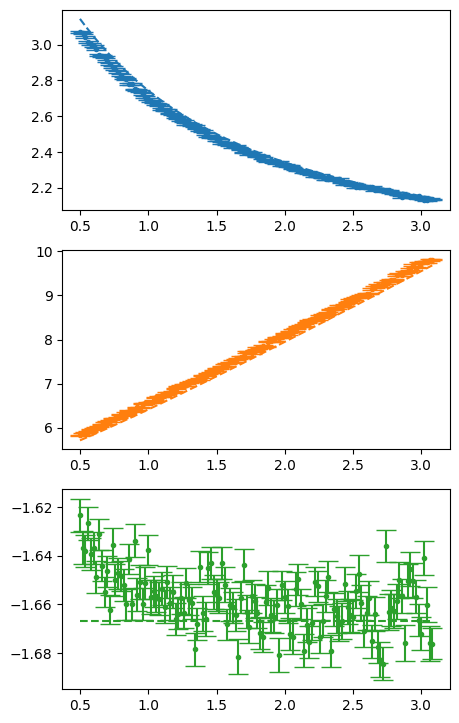

In [53]:
plt.figure(figsize=(5,9), dpi=100)
factor=1

for i,(lbl, lbl2) in enumerate(zip(["xx","vxvx","xvy"], ["R","S", "H"])):
    plt.subplot(3,1,i+1)
#     NN=df[lbl][len(df)//2+1]

    plt.plot(df.A[::2], df[lbl2][::2],"--",label=f"{lbl2} theory", c=COLORS[i])

    plt.errorbar(df.A[::2], df[lbl][::2], yerr=df[lbl+"_err"][::2]*factor, capsize=7, marker="o", ls="none", ms=3,
                     label=f"{lbl}", c=COLORS[i])
#     plt.twinx()
    
# plt.legend()
# plt.plot(df.A, df.Rx,df.A, df.Sx,df.A, df.Hx)
# plt.errorbar()

<ErrorbarContainer object of 3 artists>

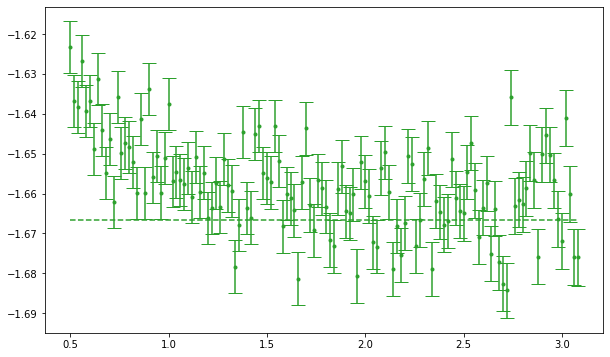

In [49]:
plt.figure(figsize=(10,6))
plt.plot(df.A[::2], df["H"][::2],"--",label=f"H theory", c=COLORS[i])

plt.errorbar(df.A[::2], df["xvy"][::2], yerr=df["xvy_err"][::2]*1, capsize=7, marker="o", ls="none", ms=3,
                 label="xvy", c=COLORS[i])

<ErrorbarContainer object of 3 artists>

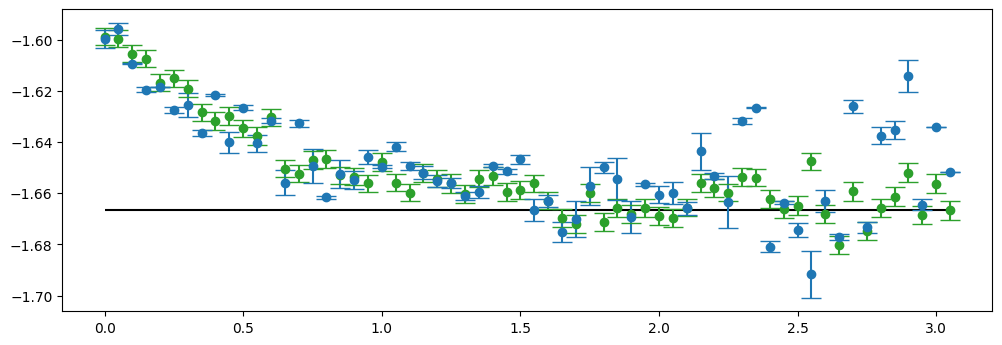

In [28]:
plt.figure(figsize=(12,4), dpi=100)
plt.hlines(y=df.H[0], xmin=df.A.min(), xmax=df.A.max())
g0kasq=g0 * ka**2


plt.errorbar(df.A, df.xvy, yerr=df.xvy_err*factor, capsize=7, marker="o", ls="none", 
                     label=f"{lbl}", c=COLORS[2])
plt.errorbar(df.A, df.H[0]*(1+df.uzvz) + df.uxry/g0kasq, yerr=(df.uxry+df.uyrx)/2/g0kasq*factor, capsize=7, marker="o", ls="none", 
                     label=f"{lbl}")


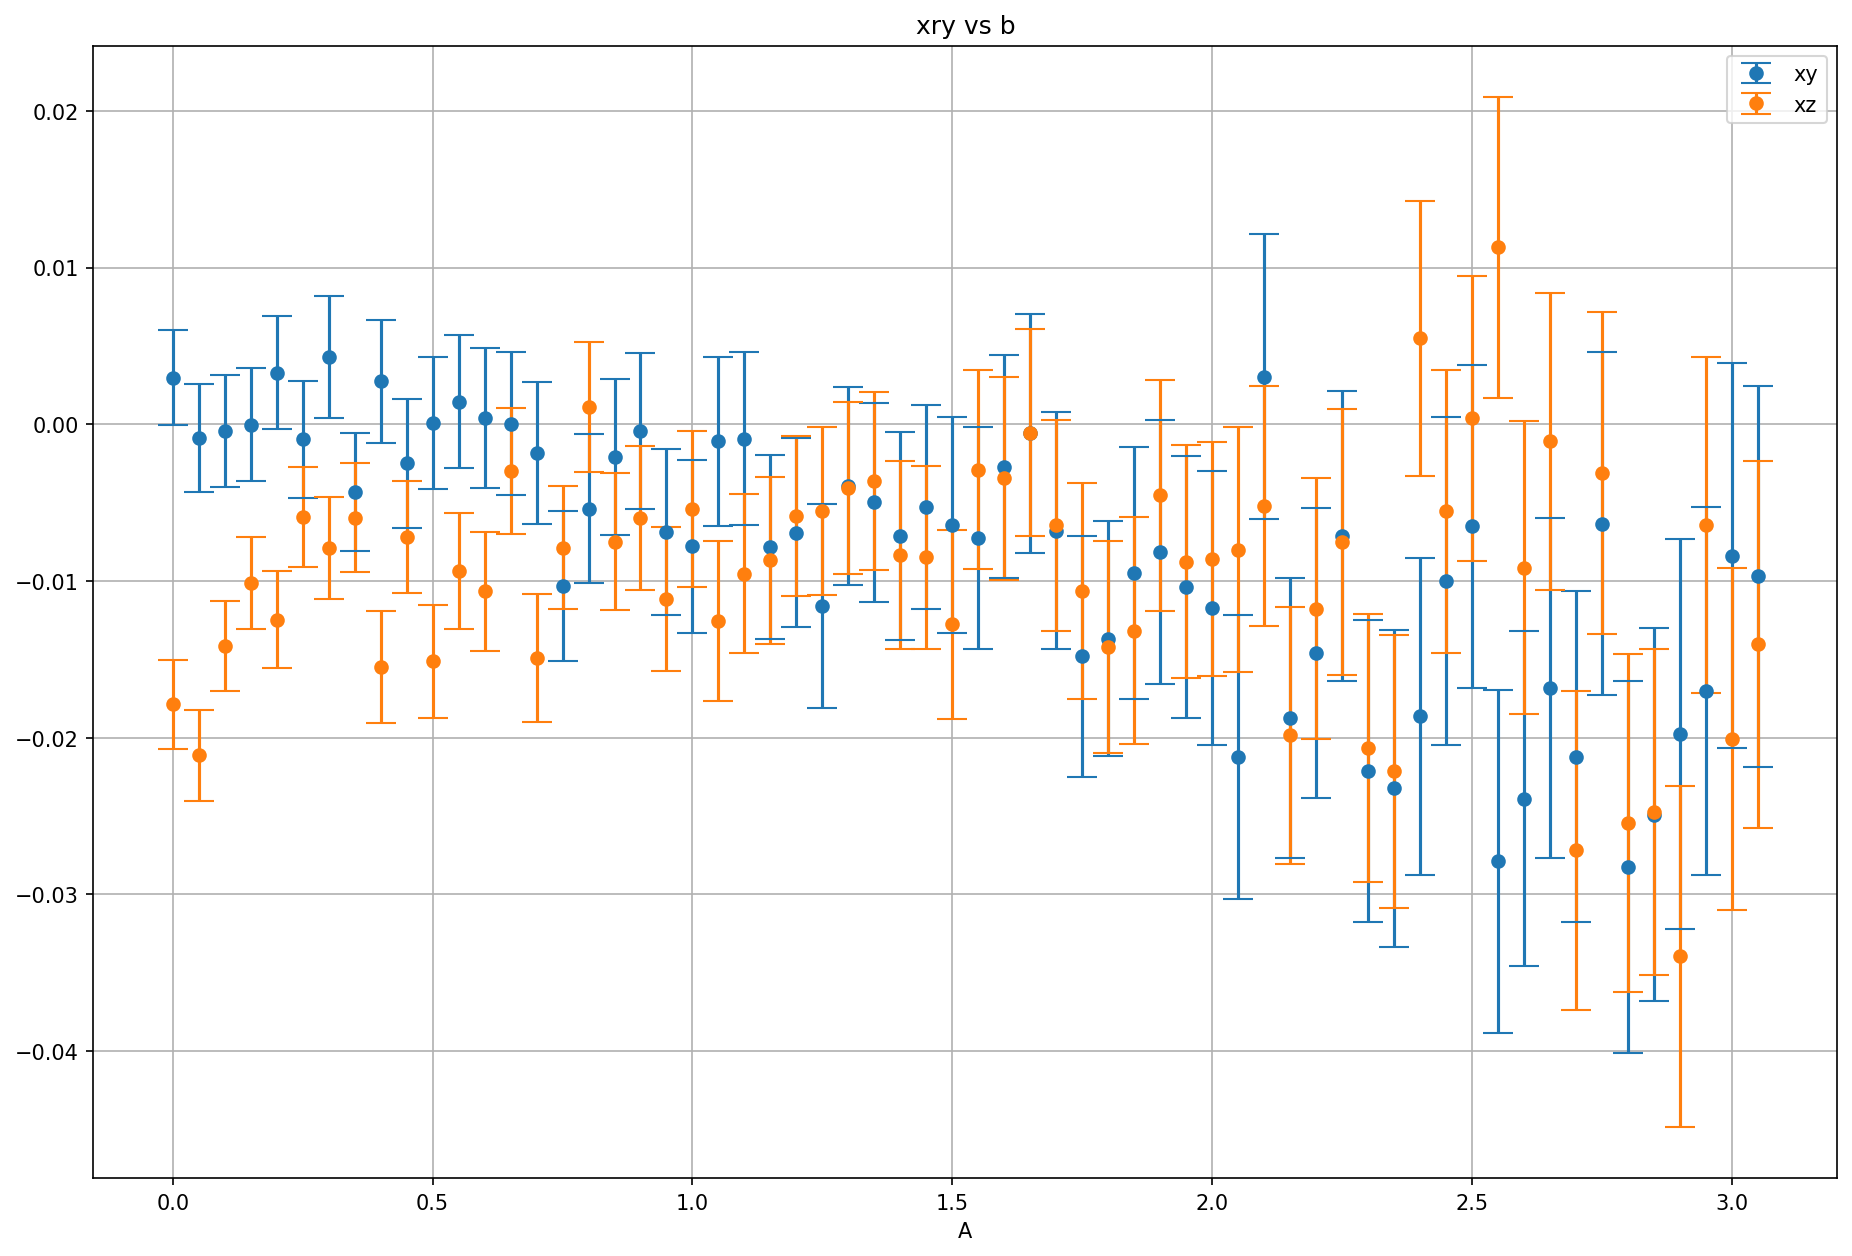

In [29]:
plt.figure(figsize=(15,10), dpi=150)
plt.title("xry vs b")
plt.xlabel("A");plt.ylabel("")

plt.errorbar(df.A, df.uxvx, yerr=df.uxvx_err, capsize=7, marker="o", ls="none", label="xy")
plt.errorbar(df.A, df.uzvz, yerr=df.uzvz_err, capsize=7, marker="o", ls="none", label="xz")

plt.grid()
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

In [35]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

In [30]:
values = results[:,:2,:,stationari_treshold:].reshape(results.shape[0],-1)
moment2 = np.mean(values**2, axis=1)
moment3 = np.mean(values**3, axis=1)
moment4 = np.mean(values**4, axis=1)

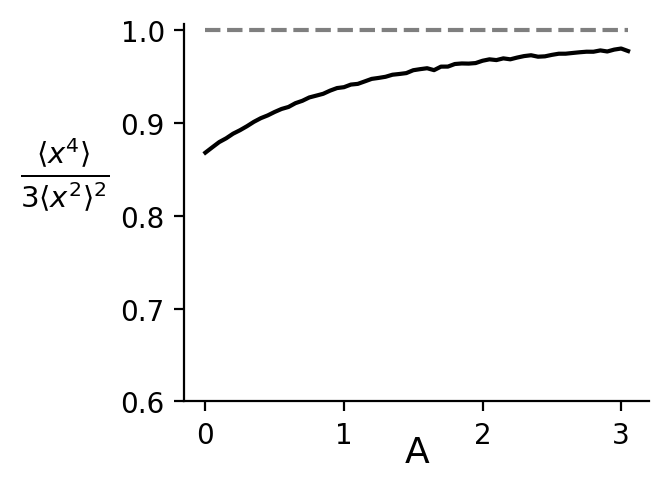

In [31]:
plt.figure(figsize=(3,2.5), dpi=200)
plt.plot(df.A,moment4/moment2**2/3, c="k")
plt.hlines(y=1, xmin=min(df.A), xmax=max(df.A), ls="--", alpha=0.5)
# plt.title("moments ratio for position")
plt.yticks(np.arange(0.6,1.01,0.1))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel("A",fontdict={"size":13},labelpad=-5)
plt.ylabel(r"$\frac{\langle x^4\rangle}{3 \langle x^2\rangle^2}$", rotation=0, labelpad=20,  fontsize=15)
plt.savefig("cumulant_check.pdf", bbox_inches = 'tight',
    pad_inches = 0.08)

In [48]:
x,y,z,vx,vy,vz,rx,ry,rz = results[...,stationari_treshold::].reshape(
    results.shape[0], results.shape[1],-1).transpose(1,0,2)


In [49]:
x,y,z,vx,vy,vz,rx,ry,rz = results[...,stationari_treshold::].transpose(1,0,2,3)

In [50]:
uxry1=(B* ((x**3*ry) + (y**2*x*ry) + (z**2*x*ry))).mean(axis=1)

### Plots to publish

In [53]:
from nsdesolve import U_2

In [65]:
factor = 3

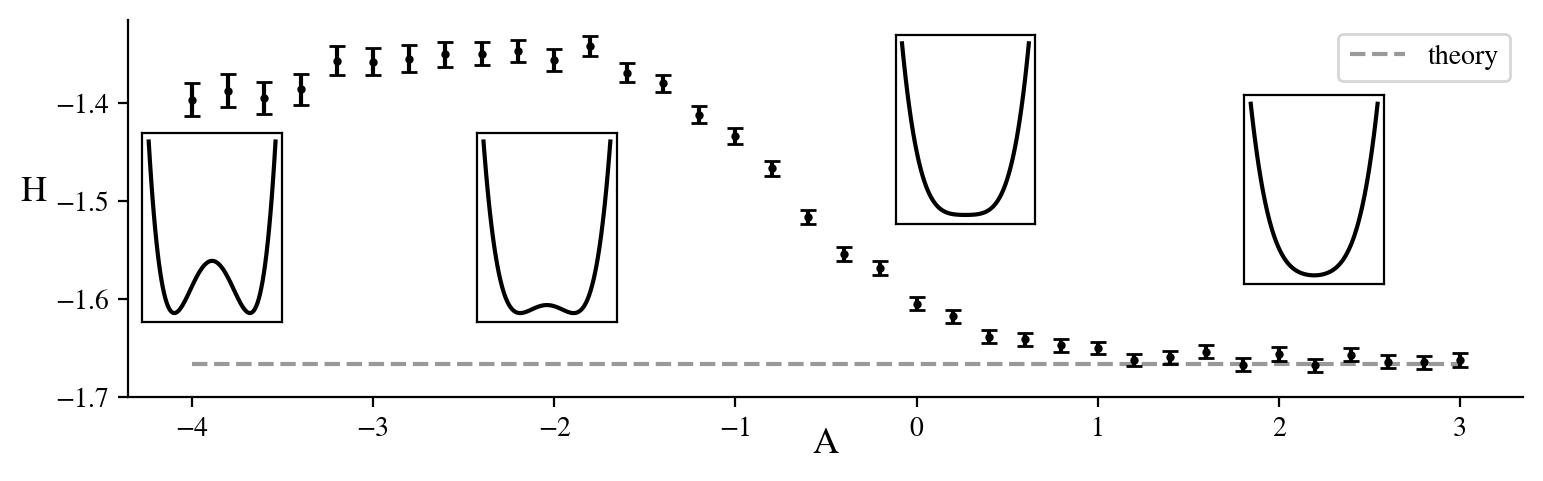

In [69]:
plt.figure(figsize=(9,2.5), dpi=200)

plt.plot(df.A, df["H"],"--",label=f"theory", c="k", alpha=0.4)

plt.errorbar(df.A, df["xvy"], yerr=df["xvy_err"]*factor, capsize=3, marker="o", ls="none", ms=2,
                c="k")
plt.xlabel("A",labelpad=-5,fontdict={"size":13})
plt.ylabel("H",rotation=0,labelpad=8,fontdict={"size":13})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.yticks(np.arange(-1.70,-1.31, 0.1))
ins = plt.gca().inset_axes([0.01,0.2,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(-4,B, 0,0,0, r, np.zeros_like(r)), c="k");


ins = plt.gca().inset_axes([0.25,0.2,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(-2,B, 0,0,0, r, np.zeros_like(r)), c="k");

ins = plt.gca().inset_axes([0.55,0.46,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(0.5,B, 0,0,0, r, np.zeros_like(r)), c="k");

ins = plt.gca().inset_axes([0.8,0.3,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(2.3,B, 0,0,0, r, np.zeros_like(r)), c="k");

plt.legend()
plt.savefig("H_plot.pdf", bbox_inches = 'tight', pad_inches = 0.08)

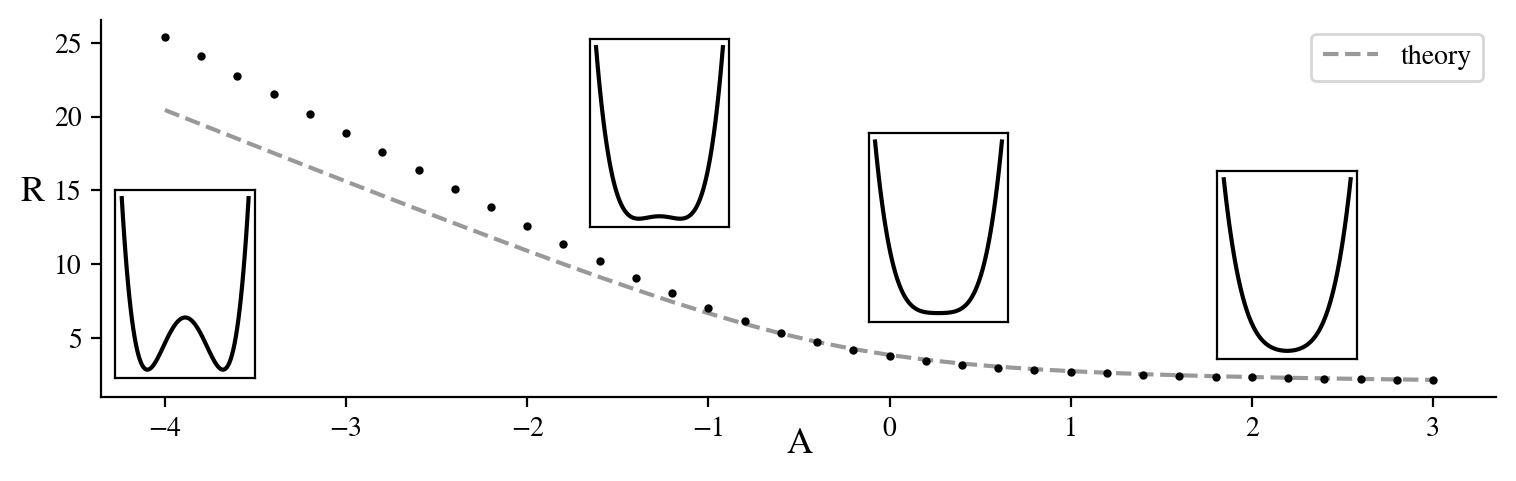

In [70]:
plt.figure(figsize=(9,2.5), dpi=200)

plt.plot(df.A, df["R"],"--",label=f"theory", c="k", alpha=0.4)

# plt.errorbar(df.A, df["xx"], yerr=df["xx_err"]*factor, capsize=5, marker="o", ls="none", ms=2,
#                 c="k")
plt.plot(df.A, df["xx"], marker="o", ls="none", ms=2, c="k")

plt.xlabel("A",labelpad=-5,fontdict={"size":13})
plt.ylabel("R",rotation=0,labelpad=8,fontdict={"size":13})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.yticks(np.arange(-1.70,-1.31, 0.1))

ins = plt.gca().inset_axes([0.01,0.05,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(-4,B, 0,0,0, r, np.zeros_like(r)), c="k");


ins = plt.gca().inset_axes([0.35,0.45,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(-1.2,B, 0,0,0, r, np.zeros_like(r)), c="k");

ins = plt.gca().inset_axes([0.55,0.2,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(0.5,B, 0,0,0, r, np.zeros_like(r)), c="k");

ins = plt.gca().inset_axes([0.8,0.1,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(2.3,B, 0,0,0, r, np.zeros_like(r)), c="k");

plt.legend()
plt.savefig("R_plot.pdf",bbox_inches = 'tight',
    pad_inches = 0.08)